<a href="https://colab.research.google.com/github/luizleroy/predictive_analytics/blob/develop/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction to Predictive Analysis with Colab and Python**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href=""><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/luizleroy/predictive_analytics/blob/develop/new.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Welcome to this Colab! I will get a quick introduction to the Analysis with Colab and Python to Predictive Analysis.

Colab is a Python development environment that runs in the browser using Google Cloud.

Agora, vamos na língua de Camões mesmo, hehehe. Pois, o principal objetivo aqui é criar insumos, 'pedaços' de código mesmo, para utilizar em projetos de P&D.

**Algoritmos preditivos**

A proposta nesta Pesquisa & Desenvolvimento (P&D) é entregar um sistema com os seguintes grupos de algoritmos:

*   Os situacionais de DEC e FEC, implantando relatórios na plataforma PTC referentes a dados que já existem em outras plataformas nas concecionários hoje.
*   Implementar um grupo de algoritmos preditivos, ou seja, no início do ano, sem informações futuras, devo rodar um cálculo, usando alguma(s) metodologia(s) que prevê(êm) como será o comportamento (DEC, FEC, índices regulamentados) dos circuitos elétricos - os conjuntos Aneel - no ano vindouro. Segue abaixo algumas questões reflexivas:

*   Quais conjuntos ficarão acima da meta e quais ficarão dentro (abaixo) da meta?
*   Como a meteorologia influencia nestes índices regulamentados? 
  1.   É possível emular um ano com baixa incidência de chuvas e / ou rajadas?
  2.   E a temperatura, influencia em MG? Ou apenas em estados como o RJ, que possui alto índice de utilização de refrigeração forçada?

Para o(s) Algoritmos Preditivos, as informações que temos, no momento, são:
0. Tabelas de metas para DEC e FEC dos conjuntos (informação privada).
1. Topologia da rede elétrica por alimentador e conjunto, onde sei quem é urbano e quem é rural (informação privada).
2. Dados de DEC FEC históricos, creio que com 3 anos de históricos eu consigo ver o comportamento dos conjuntos ao longo do ano (sazonalidades) e consigo fazer através de regressão linear, uma previsão se o conjunto vai manter, abaixar ou superar sua meta se nada for investido nele... **Esta informação é pública, e encontra-se no site da Aneel [aqui](https://www.aneel.gov.br/indicadores-coletivos-de-continuidade)**
3. **Meteorologia** para DEC e FEC: rajada + chuva podem aumentar a quantidade de interrupções (informação pública no site do INMET .gov).

A premissa aqui é que, com os dados acima, os algoritmos preditivos aqui descritos e, o apoio dos parceiros do projeto com unidades computacionais, dicas e conselhos técnicos - possivelmente - conseguiremos implementar a previsão para DEC urbano e rural em toda região da CEMIG.

Principais hipóteses de trabalho:
1. Influência de manutenção, eficiente ou e principalmente ineficiente, em redes e mensuração de impacto nos índices regulamentados.
2. Influência meteorológica, rajada e chuvas, nos índices regulamentados.

# Imports

In [1]:
#!pip install sklearn

In [2]:
import numpy as np
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_score

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn.model_selection import cross_val_score

from sklearn import datasets, linear_model

import random

# Tratamentos de dados de entrada para treinamento e validação

Será necessário tratar dados reais. Sempre é. Deixarei aqui um 'log' para possíveis tratamentos.

Geralmente é considerado o percentual de 5% para o atributo ser considerado Raro, o que causaria overfitting. Em algumas situações onde exitem poucos atributos, pode ser que sejam úteis esses atributos raros. Porém, se a variável possuir muitos atributos, deve ser descartado.

Formas de tratar os atributos raros:
*   Substituir o atributo raro para o atributo mais frequente.
*   Agrupar os atributos em uma nova categoria (exemplo: raro, outros).
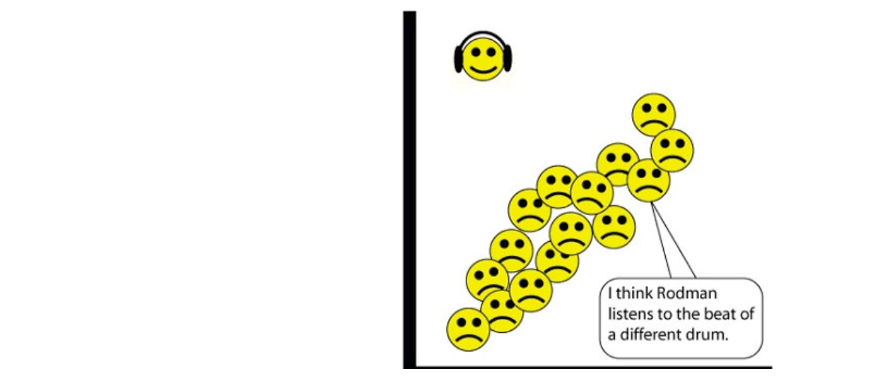

FONTE: https://medium.com/@alegeorgelustosa/an%C3%A1lise-explorat%C3%B3ria-e-preditiva-do-dataset-titanic-em-python-fbd5e5bb7328#

**TODO** inserir 'TODOS' tratamentos.

# [TEST01] Quarteto de Anscombe

Quarteto de Anscombe são quatro conjuntos de dados que têm estatísticas descritivas quase idênticas (como a média e a variância), mas que têm distribuições muito diferentes e aparências muito distintas quando exibidos graficamente. Cada conjunto de dados consiste de onze pontos (x,y). Eles foram construídos em 1973 pelo estatístico Francis Anscombe, com o objetivo de demonstrar tanto a importância de se visualizar os dados antes de analisá-los, quanto o efeito dos outliers e outras observações influentes nas propriedades estatísticas. Ele descreveu o artigo como tendo a finalidade de combater a impressão entre os estatísticos de que "cálculos numéricos são exatos, mas gráficos são aproximados/grosseiros."[1]
* Fonte: https://pt.wikipedia.org/wiki/Quarteto_de_Anscombe
[1] Referência: https://www.tandfonline.com/doi/abs/10.1080/00031305.1973.10478966

In [3]:
# !ls sample_data

In [4]:
data = pd.read_json('sample_data/anscombe.json')
input_data = data['X']
output_data = data['Y']
X1 = input_data[0:11]
Y1 = output_data[0:11].values
Y2 = output_data[11:22].values
Y3 = output_data[22:33].values

X4 = input_data[33:44].values
Y4 = output_data[33:44].values
ascombe = {
            "X": X1,
            "Y1":Y1,
            "Y2":Y2,
            "Y3":Y3,
            "X4":X4,
            "Y4":Y4,
}
data_para_treinamento_ascombe = pd.DataFrame(ascombe)
print(data_para_treinamento_ascombe)
print('-----------------------------------------------------------------------')
data_para_treinamento_ascombe.describe()

     X     Y1    Y2     Y3  X4     Y4
0   10   8.04  9.14   7.46   8   6.58
1    8   6.95  8.14   6.77   8   5.76
2   13   7.58  8.74  12.74   8   7.71
3    9   8.81  8.77   7.11   8   8.84
4   11   8.33  9.26   7.81   8   8.47
5   14   9.96  8.10   8.84   8   7.04
6    6   7.24  6.13   6.08   8   5.25
7    4   4.26  3.10   5.39  19  12.50
8   12  10.84  9.13   8.15   8   5.56
9    7   4.81  7.26   6.42   8   7.91
10   5   5.68  4.74   5.73   8   6.89
-----------------------------------------------------------------------


,X,Y1,Y2,Y3,X4,Y4
count,11.000000,11.00000,11.000000,11.000000,11.000000,11.000000
mean,9.000000,7.50000,7.500909,7.500000,9.000000,7.500909
std,3.316625,2.03289,2.031657,2.030424,3.316625,2.030579
min,4.000000,4.26000,3.100000,5.390000,8.000000,5.250000
25%,6.500000,6.31500,6.695000,6.250000,8.000000,6.170000
50%,9.000000,7.58000,8.140000,7.110000,8.000000,7.040000
75%,11.500000,8.57000,8.950000,7.980000,8.000000,8.190000
max,14.000000,10.84000,9.260000,12.740000,19.000000,12.500000


Text(0.5, 1.0, 'Três primeiras funções do Quarteto de Anscombe [Inversa]')

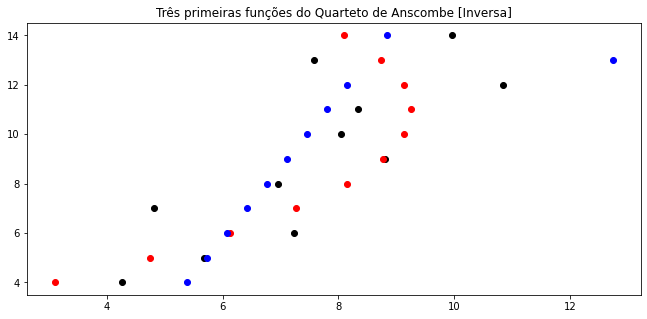

In [5]:
plt.figure(figsize=(11,5))
ax = plt.axes()
ax.plot(data_para_treinamento_ascombe.iloc[:,1],data_para_treinamento_ascombe.iloc[:,0],'o', color='black')
ax.plot(data_para_treinamento_ascombe.iloc[:,2],data_para_treinamento_ascombe.iloc[:,0],'o', color='red')
ax.plot(data_para_treinamento_ascombe.iloc[:,3],data_para_treinamento_ascombe.iloc[:,0],'o', color='blue')
plt.title("Três primeiras funções do Quarteto de Anscombe [Inversa]")

Text(0.5, 1.0, 'Grande Alavanca do Quarteto de Anscombe [Inversa]')

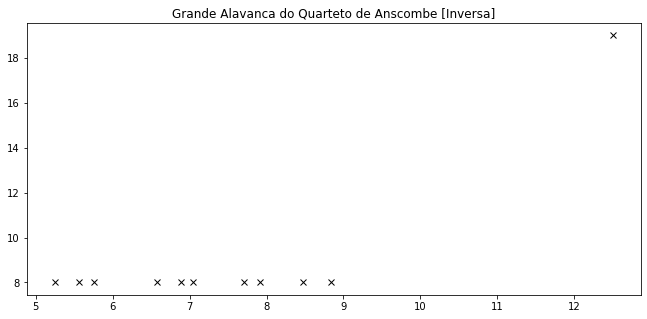

In [6]:
plt.figure(figsize=(11,5))
ax = plt.axes()
ax.plot(data_para_treinamento_ascombe.iloc[:,5],data_para_treinamento_ascombe.iloc[:,4],'x', color='black')
plt.title("Grande Alavanca do Quarteto de Anscombe [Inversa]")

**Correlação de Pearson**

Dentre as interpretações desta correlação, a que vejo como mais interessante é a geométrica. Para cada valor de *r* da matriz abaixo, interpretando o coeficiente como o cosseno do ângulo entre os dois vetores centrados, podemos ver que, para cada valor encontrado desse ângulo $\alpha$ temos a seguinte faixa de valores para interpretação  (linear entre $0^{\circ }$ e $180^{\circ }$:



1.   ${\displaystyle \alpha =0^{\circ }}
$:
os dois vetores são colineares (paralelos);
2.   ${\displaystyle \alpha =90^{\circ }}
$: os dois vetores são ortogonais; e
3.   ${\displaystyle \alpha =180^{\circ }}
$: os dois vetores são colineares, mas em direções opostas.





Fonte: [https://pt.wikipedia.org/wiki/Correla%C3%A7%C3%A3o](https://pt.wikipedia.org/wiki/Correla%C3%A7%C3%A3o)

Matriz simétrica, de correlação, **R**:
\begin{equation} \bf{R} = \begin{bmatrix} 
r_{11} = 1 & r_{12} & r_{13} & · · · & r_{1p} 
\\ r_{21}& r_{22} = 1  & r_{23} & · · · & r_{2p} 
\\ r_{31} & r_{32} & r_{33}  = 1 & · · · & r_{3p} 
\\ · · · & · · · & · · · & · · · & · · ·
\\ r_{p1} & r_{p2} & r_{p3} & · · · & r_{pp} = 1 
\end{bmatrix}, \\\end{equation}

onde cada valor acima é a correlação calculada (na fórmula abaixo) entre os vetores **x** de {1,2, ...,p},

\begin{equation*}
  r_{jk} =
  \frac{ \sum_{i=1}^{n}(x_{ij}-\bar{x}_j)(x_{ik}-\bar{x}_k) }{%
        \sqrt{\sum_{i=1}^{n}(x_{ij}-\bar{x}_j)^2}\sqrt{\sum_{i=1}^{n}(x_{ik}-\bar{x}_k)^2}}.
\end{equation*}


Text(0.5, 0.98, 'ANSCOMBE')

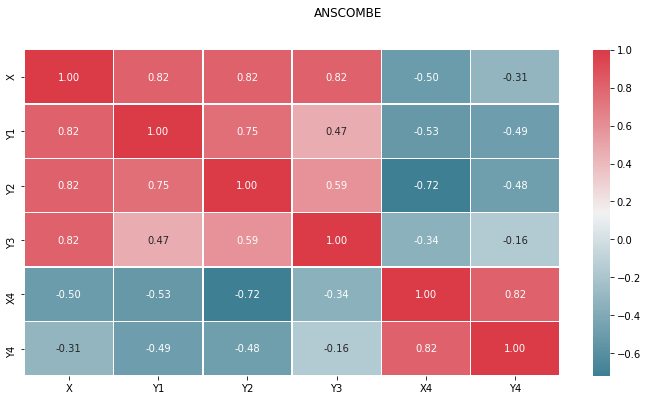

In [7]:
df = pd.DataFrame(data_para_treinamento_ascombe,columns=['X','Y1','Y2', 'Y3', 'X4', 'Y4'])
corrMatrix = df.corr()
cmap = sns.diverging_palette(220,10,as_cmap=True)
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(corrMatrix,annot=True,linewidths=0.5,ax=ax,fmt='.2f',cmap=cmap)
fig.suptitle("ANSCOMBE")

**Experimentos com algoritmo de predição SVC**

A função f(Y1,Y2,Y3) = X, onde X são números naturais, foi criada com os dados dos três primeiros conjuntos de Anscombe. Invertendo abicissa e ordenada pois é necessário que a saída da classificação seja um padrão discreto (número natural).

**Glossário:**

Support Vector Machine (SVM)

Um conceito na ciência da computação para um conjunto de métodos de aprendizado supervisionado que analisam os dados  e reconhecem padrões. Usado para classificação e análise de regressão (wikipédia).

C-Support Vector Classification (SVC)

Dados de entrada como inversa das três primeiras funções de Anscombe.

In [8]:
Input = data_para_treinamento_ascombe.iloc[:,1:4]
output = data_para_treinamento_ascombe.iloc[:,0].to_frame()

Teste inicial exploratório, com todos os registros e sem FIT.

In [9]:
clf = SVC(gamma='auto')
clf.fit(Input,np.ravel(output))
print('results:')
print('10 ->',clf.predict([[8.04,9.14,7.46]]))
print('8 ->',clf.predict([[6.95,8.14,6.77]]))
print('13 ->',clf.predict([[7.58,8.74,12.74]]))
print('9 ->',clf.predict([[8.81,8.77,7.11]]))
print('11 ->',clf.predict([[8.33,9.26,7.81]]))
print('14 ->',clf.predict([[ 9.96,8.1,8.84]]))
print('6 ->',clf.predict([[7.24,6.13,6.08]]))
print('4 ->',clf.predict([[4.26,3.10,5.39]]))
print('12 ->',clf.predict([[10.84,9.13,8.15]]))
print('7 ->',clf.predict([[4.81,7.26,6.42]]))
print('5 ->',clf.predict([[5.68,4.74,5.73]]))
print('...')

results:
10 -> [10]
8 -> [8]
13 -> [13]
9 -> [9]
11 -> [11]
14 -> [14]
6 -> [6]
4 -> [4]
12 -> [12]
7 -> [7]
5 -> [5]
...


**Transformação**

In [15]:
scaler = StandardScaler()
#Input = Input.to_numpy().reshape(1,-1)
Input = scaler.fit_transform(Input,y=output)
Input = pd.DataFrame(Input,columns=['Y1','Y2', 'Y3'])
print("Depois do FIT:")
print(Input)
print(output)
print('-----------------------------------------------------------------------')
Input.describe()

Depois do FIT:
          Y1        Y2        Y3
0   0.278597  0.846153 -0.020662
1  -0.283756  0.329920 -0.377079
2   0.041274  0.639660  2.706705
3   0.675855  0.655147 -0.201453
4   0.428214  0.908101  0.160130
5   1.269164  0.309271  0.692173
6  -0.134139 -0.707709 -0.733496
7  -1.671582 -2.271896 -1.089914
8   1.723174  0.840991  0.335755
9  -1.387825 -0.124365 -0.557871
10 -0.938975 -1.425273 -0.914288
     X
0   10
1    8
2   13
3    9
4   11
5   14
6    6
7    4
8   12
9    7
10   5
-----------------------------------------------------------------------


,Y1,Y2,Y3
count,1.100000e+01,1.100000e+01,1.100000e+01
mean,-2.018587e-17,2.018587e-17,-1.009294e-17
std,1.048809e+00,1.048809e+00,1.048809e+00
min,-1.671582e+00,-2.271896e+00,-1.089914e+00
25%,-6.113655e-01,-4.160371e-01,-6.456835e-01
50%,4.127362e-02,3.299200e-01,-2.014533e-01
75%,5.520346e-01,7.480690e-01,2.479425e-01
max,1.723174e+00,9.081013e-01,2.706705e+00


Aumentando entradas para mais de 100 registros...

In [17]:
frames = [Input, Input, Input, Input, Input, Input, Input, Input, Input, Input]
Input = pd.concat(frames)
frames = [output, output, output, output, output, output, output, output, output, output]
output = pd.concat(frames)

In [21]:
num_folds = 10
modelos = []

modelos.append(('SVC', SVC()))
modelos.append(('lasso', linear_model.Lasso()))
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('ADA', AdaBoostClassifier()))
modelos.append(('GBM', GradientBoostingClassifier()))
modelos.append(('RF', RandomForestClassifier()))
modelos.append(('XGB', xgb.XGBClassifier()))

resultados = []
kfold = model_selection.KFold(n_splits=num_folds)
print(kfold)
for nome, modelo in modelos:
  cv_results = model_selection.cross_val_score(modelo,Input,np.ravel(output),cv=kfold)
  resultados.append([nome, cv_results])

for nome, cv_results in resultados:
  print(nome,"%0.2f accuracy with a standard deviation of %0.2f" % (cv_results.mean(), cv_results.std()))

KFold(n_splits=10, random_state=None, shuffle=False)
SVC 1.00 accuracy with a standard deviation of 0.00
lasso 0.78 accuracy with a standard deviation of 0.00
LR 1.00 accuracy with a standard deviation of 0.00
LDA 1.00 accuracy with a standard deviation of 0.00
NB 1.00 accuracy with a standard deviation of 0.00
KNN 1.00 accuracy with a standard deviation of 0.00
CART 1.00 accuracy with a standard deviation of 0.00
ADA 0.45 accuracy with a standard deviation of 0.00
GBM 1.00 accuracy with a standard deviation of 0.00
RF 1.00 accuracy with a standard deviation of 0.00
XGB 1.00 accuracy with a standard deviation of 0.00


In [22]:
print()
for result in resultados:
  print(result)


['SVC', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
['lasso', array([0.78342478, 0.78342478, 0.78342478, 0.78342478, 0.78342478,
       0.78342478, 0.78342478, 0.78342478, 0.78342478, 0.78342478])]
['LR', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
['LDA', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
['NB', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
['KNN', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
['CART', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
['ADA', array([0.45454545, 0.45454545, 0.45454545, 0.45454545, 0.45454545,
       0.45454545, 0.45454545, 0.45454545, 0.45454545, 0.45454545])]
['GBM', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
['RF', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]
['XGB', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


**Grande Alavanca submetida ao SVC**

In [23]:
Input = data_para_treinamento_ascombe.iloc[:,5]
output = data_para_treinamento_ascombe.iloc[:,4].to_frame()

In [24]:
clf = SVC(gamma='auto')
clf.fit(Input.to_numpy().reshape(-1,1),np.ravel(output))
print('results:')
print('8 ->',clf.predict([[6.58]]))
print('8 ->',clf.predict([[5.76]]))
print('...')
print('8 ->',clf.predict([[7.04]]))
print('...')
print('19 ->',clf.predict([[12.5]]))
print('...')
print('8 ->',clf.predict([[6.89]]))

results:
8 -> [8]
8 -> [8]
...
8 -> [8]
...
19 -> [19]
...
8 -> [8]


# [TEST02] Base de Dados de (Predição) Diabetes BDD

**Análise e pré-processamento**

In [26]:
diabetes = datasets.load_diabetes()
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [29]:
X = diabetes.data
y = diabetes.target
dfy = pd.DataFrame(y,columns=['y'])
dfX = pd.DataFrame(X)

In [31]:
frames = [dfX,dfy]
df = pd.concat(frames,axis=1)
df.describe()

,0,1,2,3,4,5,6,7,8,9,y
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


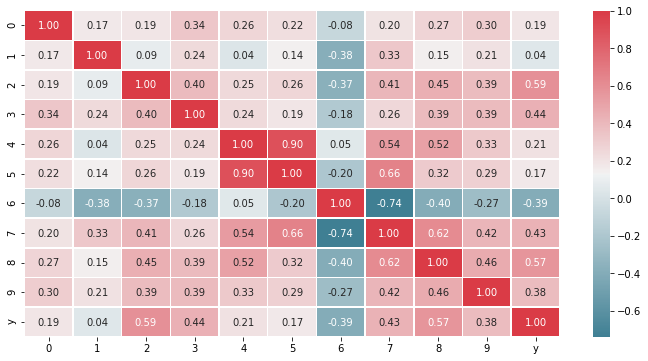

In [28]:
corrMatrix = df.corr()
cmap = sns.diverging_palette(220,10,as_cmap=True)
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(corrMatrix,annot=True,linewidths=0.5,ax=ax,fmt='.2f',cmap=cmap)

**Validação exploratória para predição da BDD**

In [33]:
X = diabetes.data[:150] #teste manual
y = diabetes.target[:150]

In [34]:
clf = SVC(gamma='auto')
clf.fit(X,y)
print('--- Análise dos dados de entrada: ---')
data_aleatorio = random.randint(0,len(diabetes.target))
print(diabetes.data[data_aleatorio])
print('target:',diabetes.target[data_aleatorio])
print('--- Análise de um resultado, ponto aleatório: ---')
target = clf.predict(diabetes.data[data_aleatorio].reshape(1,-1))
print('X[',data_aleatorio,']-> ',target)
print('Erro:',100*(target - diabetes.target[data_aleatorio])/diabetes.target[data_aleatorio],'%')

--- Análise dos dados de entrada: ---
[-0.00914709  0.05068012  0.00133873 -0.00222774  0.07961226  0.07008397
  0.03391355 -0.00259226  0.02671426  0.08176444]
target: 142.0
--- Análise de um resultado, ponto aleatório: ---
X[ 309 ]->  [128.]
Erro: [-9.85915493] %


In [35]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X,y)
print('--- Análise dos dados de entrada: ---')
data_aleatorio = random.randint(0,len(diabetes.target))
print(diabetes.data[data_aleatorio])
print('target:',diabetes.target[data_aleatorio])
print('--- Análise de um resultado, ponto aleatório: ---')
target = clf.predict(diabetes.data[data_aleatorio].reshape(1,-1))
print('X[',data_aleatorio,']-> ',target)
print('Erro:',100*(target - diabetes.target[data_aleatorio])/diabetes.target[data_aleatorio],'%')

--- Análise dos dados de entrada: ---
[-0.07453279 -0.04464164 -0.02345095 -0.00567061 -0.0208323  -0.01415296
  0.01550536 -0.03949338 -0.03845911 -0.03007245]
target: 144.0
--- Análise de um resultado, ponto aleatório: ---
X[ 312 ]->  [129.62536869]
Erro: [-9.98238285] %


**Análise formal de resultados para vários algoritmos**

In [36]:
X = diabetes.data
y = diabetes.target

# scaler = StandardScaler()
# fit = scaler.fit_transform(data_para_treinamento_ascombe)
# dfn = pd.DataFrame(fit,columns=['X','Y1','Y2', 'Y3', 'X4', 'Y4'])

In [37]:
num_folds = 5
num_instances=len(X)
#seed = 7 TO random_state=seed
modelos = []

modelos.append(('SVC', SVC()))
modelos.append(('lasso', linear_model.Lasso()))
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('ADA', AdaBoostClassifier()))
modelos.append(('GBM', GradientBoostingClassifier()))
modelos.append(('RF', RandomForestClassifier()))
modelos.append(('XGB', xgb.XGBClassifier()))

resultados = []
for nome, modelo in modelos:
  kfold = model_selection.KFold(n_splits=num_folds, shuffle=True)
  cv_results = model_selection.cross_val_score(modelo,X,y,cv=kfold)
  resultados.append([nome, cv_results])


In [ ]:
for nome, cv_results in resultados:
  print(nome,"%0.2f accuracy with a standard deviation of %0.2f" % (cv_results.mean(), cv_results.std()))
print()
# for result in resultados:
#   print(result)

SVC 0.00 accuracy with a standard deviation of 0.01
lasso 0.33 accuracy with a standard deviation of 0.05
LR 0.00 accuracy with a standard deviation of 0.00
LDA 0.01 accuracy with a standard deviation of 0.01
NB 0.00 accuracy with a standard deviation of 0.01
KNN 0.00 accuracy with a standard deviation of 0.00
CART 0.00 accuracy with a standard deviation of 0.01
ADA 0.00 accuracy with a standard deviation of 0.00
GBM 0.01 accuracy with a standard deviation of 0.01
RF 0.01 accuracy with a standard deviation of 0.01
XGB 0.01 accuracy with a standard deviation of 0.01



In [42]:
iris = datasets.load_iris()
boston = datasets.load_boston()
digits = datasets.load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

# Manter no final: Main_Test :(

In [ ]:
# randomica = pd.DataFrame(np.random.randint(-500,7000,size=(100, 4)), columns=list('ABCD'))
# df = pd.DataFrame(randomica,columns=['A','B','C','D'])
# print(df)
# corrMatrix = df.corr()
# cmap = sns.diverging_palette(220,10,as_cmap=True)
# fig, ax = plt.subplots(figsize=(12,6))
# sns.heatmap(corrMatrix,annot=True,linewidths=0.5,ax=ax,fmt='.2f',cmap=cmap)
# fig.suptitle("SEM Normalização")

# scaler = StandardScaler()
# fit = scaler.fit_transform(randomica)
# dfn = pd.DataFrame(fit,columns=['A','B','C','D'])
# print(dfn)
# corrMatrix = dfn.corr()
# cmap = sns.diverging_palette(220,10,as_cmap=True)
# fig, ax = plt.subplots(figsize=(12,6))
# sns.heatmap(corrMatrix,annot=True,linewidths=0.5,ax=ax,fmt='.2f',cmap=cmap)
# fig.suptitle("COM Normalização")